In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

In [2]:
df = pd.read_excel("D:/Học tập/Học kì 20231/Đồ án 2/Code/realdata.xlsx")
df = df.drop([0,1,2,3,4])
df.columns = df.iloc[0]
df.set_index("TT", inplace= True)
df = df.iloc[1:]

In [3]:
Lop = [df['Lớp'].iloc[i][0] for i in range(len(df))]

In [4]:
data = pd.DataFrame(df['Toán'].copy())
data['Category'] = Lop
data = data[data['Toán']!=-1]

In [5]:
Category = data['Category'].unique()
data_fre = pd.DataFrame(columns = ["Category", "frequency"])
for i in Category:
    num = len(data[data['Category']==i])
    data_fre = pd.concat([data_fre, pd.DataFrame({"Category": [i], "frequency": [num]})], ignore_index= True)
data_fre.sort_values(by = "Category")

,Category,frequency
7,12A1,45
3,12A2,42
1,12A3,44
2,12A4,41
13,12D1,46
8,12D10,42
4,12D11,39
0,12D2,45
11,12D3,45
5,12D4,44


In [6]:
Num = len(Category)

# Tạo từ điển các mảng một cách tự động
data_cate = {}
for i in Category:
    data_cate[f'{i}'] = data[data['Category']== i]['Toán'].values # Tạo một mảng mới và lưu vào từ điển

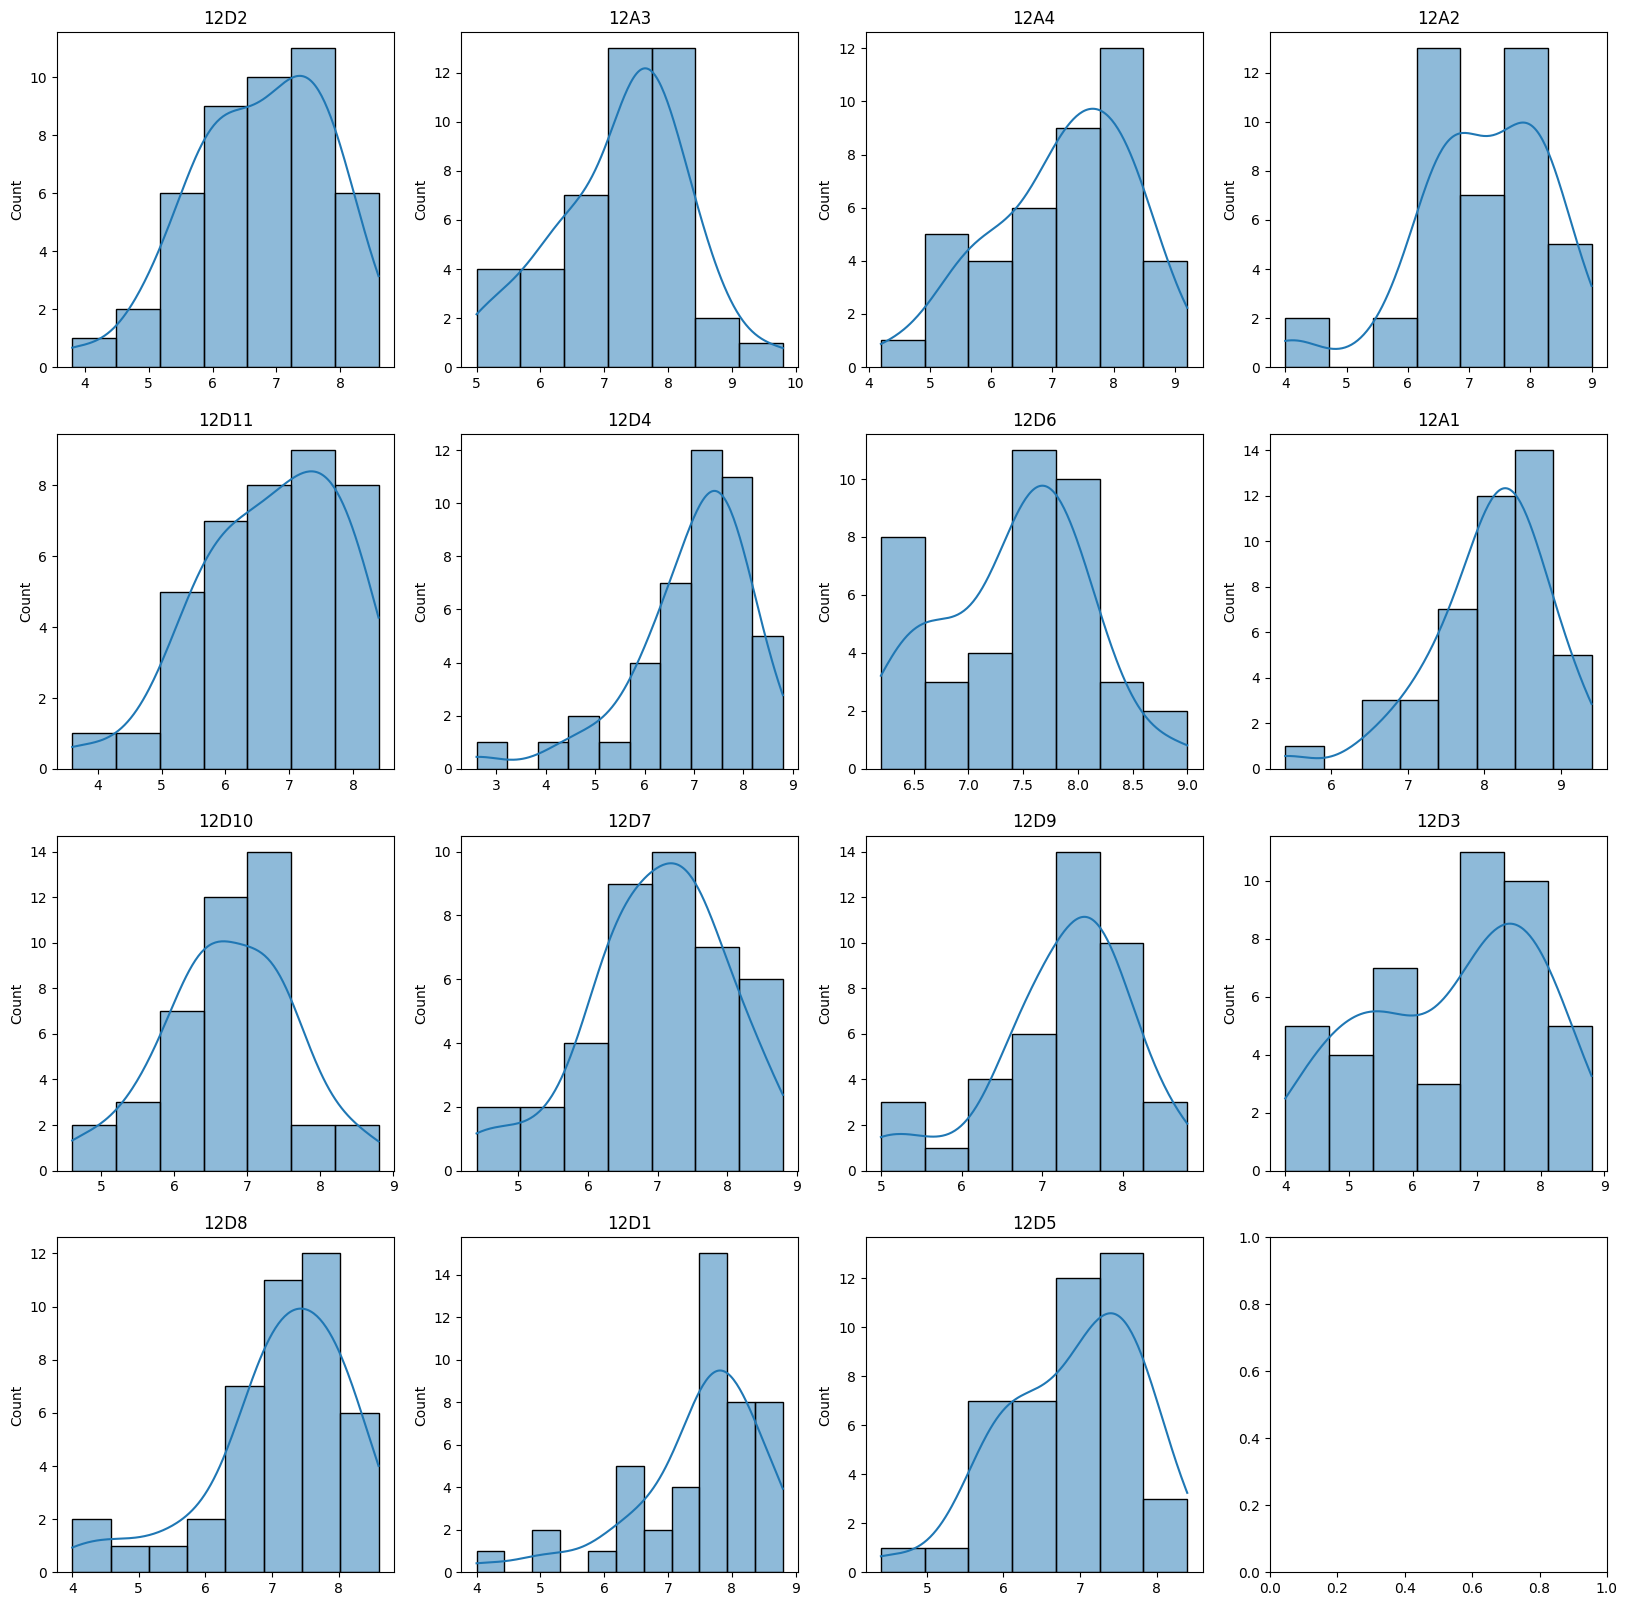

In [7]:
_, axs = plt.subplots(4, 4, figsize=(20, 20))
j = 0
k = 0
for i in Category:
    sns.histplot(data=data_cate[i], ax=axs[j,k], kde = True)
    axs[j,k].set_title(i)
    k = k+1
    k = k % 4
    if k == 0:
        j = j+1

In [8]:
data_mean = pd.DataFrame(columns=['category', 'mean'])
for i in Category:
    mean = data_cate[i].mean()
    data_mean = pd.concat([data_mean, pd.DataFrame({"category": [i], "mean": [mean]})], ignore_index= True)

In [28]:
import scipy.stats as stats

# Giả sử bạn có một DataFrame có tên df và các cột 'group1', 'group2', 'group3',...

# Levene's Test
statistic, p_value = stats.levene(*[data_cate[i] for i in Category])

# In kết quả
print("Levene Statistic:", statistic)
print("p-value:", p_value)

# So sánh p-value với mức ý nghĩa (ví dụ: 0.05) để đưa ra quyết định
if p_value < 0.05:
    print("Có bằng chứng để bác bỏ giả định phương sai bằng nhau.")
else:
    print("Không có bằng chứng để bác bỏ giả định phương sai bằng nhau.")

Levene Statistic: 2.171705939860049
p-value: 0.007701288573286561
Có bằng chứng để bác bỏ giả định phương sai bằng nhau.


In [9]:
#Tiên nghiệm của mu
mu0 = 7
gamma0 = 2
#Tiên nghiệm của 1/tau**2
shape_tau = 1.6
rate_tau  = 1.6
#Tiên nghiệm của 1/sigma**2
shape_sig = 1.6
rate_sig = 1.6

In [10]:
# Tạo tên cột "theta" với tên được đánh số từ 1 đến num_columns
theta_columns = [f"{i}" for i in Category]
columns_name = ["mu", "tau**2", "sig**2"] + theta_columns
# Tạo DataFrame với các cột mu, tau, sig và các cột theta được tạo tự động
para = pd.DataFrame( np.ones((1,  3 + len(Category))) ,columns= columns_name)
#Tính hiệu bình phương của từng nhóm
MSE = []
for i in Category:
    MSE1 = np.array(data_cate[i] - data_cate[i].mean())
    MSE.append(np.dot(MSE1, MSE1))
MSE = np.array(MSE)

In [11]:
np.random.seed(42)
#Lấy mẫu Gibbs với giai đoạn burn in
NOG = len(Category)
para_temp = para.iloc[0].values
for i in range(1, 100):
    k = 0
    for j in columns_name:
        if k == 0:
            para_temp[0] = np.random.normal(((para_temp.sum() - para_temp[0] - para_temp[1] - para_temp[2]) / para_temp[1] + mu0/gamma0)/(NOG/para_temp[1] + 1 / gamma0), (1/(NOG/para_temp[1] + 1/gamma0**2))**0.5)
            k = k +1
        elif k == 1:
            MSE_theta = para_temp - para_temp[0]
            MSE_theta = np.dot(MSE_theta, MSE_theta)  - (para_temp[1]-para_temp[0])**2 - (para_temp[2]-para_temp[0])**2
            para_temp[1] = 1 / np.random.gamma((2* shape_tau + NOG)/2,1/((2*rate_tau + MSE_theta)/2))
            k = k +1
        elif k == 2:
            para_temp[2] = 1 / np.random.gamma((2*shape_sig + len(data)/2),1/(rate_sig + MSE.sum()/2))
            k = k + 1
        else:
            para_temp[k] = np.random.normal((data_mean.iloc[k-3][1] * data_fre.iloc[k-3][1]/para_temp[2] + para_temp[0] / para_temp[1])/(data_fre.iloc[k-3][1]/ para_temp[2] + 1 /para_temp[1]),(1 / (data_fre.iloc[k-3][1]/para_temp[2] + 1 / para_temp[1]))**0.5)
            MSE1 = np.array(data_cate[data_mean.iloc[k-3][0]] - para_temp[k])
            MSE1 = np.dot(MSE1, MSE1)
            MSE[k-3] = MSE1
            k = k + 1
    para = pd.concat([para, pd.DataFrame(np.array([para_temp]), columns= columns_name)], ignore_index= True)
#Lấy mẫu Gibbs
para_temp = para.iloc[99].values
para = pd.DataFrame(np.array([para_temp]), columns= columns_name)
for i in range(1, 10000):
    k = 0
    for j in columns_name:
        if k == 0:
            para_temp[0] = np.random.normal(((para_temp.sum() - para_temp[0] - para_temp[1] - para_temp[2]) / para_temp[1] + mu0/gamma0)/(NOG/para_temp[1] + 1 / gamma0), (1/(NOG/para_temp[1] + 1/gamma0**2))**0.5)
            k = k +1
        elif k == 1:
            MSE_theta = para_temp - para_temp[0]
            MSE_theta = np.dot(MSE_theta, MSE_theta)  - (para_temp[1]-para_temp[0])**2 - (para_temp[2]-para_temp[0])**2
            para_temp[1] = 1 / np.random.gamma((2* shape_tau + NOG)/2,1/((2*rate_tau + MSE_theta)/2))
            k = k +1
        elif k == 2:
            para_temp[2] = 1 / np.random.gamma((2*shape_sig + len(data)/2),1/(rate_sig + MSE.sum()/2))
            k = k + 1
        else:
            para_temp[k] = np.random.normal((data_mean.iloc[k-3][1] * data_fre.iloc[k-3][1]/para_temp[2] + para_temp[0] / para_temp[1])/(data_fre.iloc[k-3][1]/ para_temp[2] + 1 /para_temp[1]),(1 / (data_fre.iloc[k-3][1]/para_temp[2] + 1 / para_temp[1]))**0.5)
            MSE1 = np.array(data_cate[data_mean.iloc[k-3][0]] - para_temp[k])
            MSE1 = np.dot(MSE1, MSE1)
            MSE[k-3] = MSE1
            k = k + 1
    para = pd.concat([para, pd.DataFrame(np.array([para_temp]), columns= columns_name)], ignore_index= True)

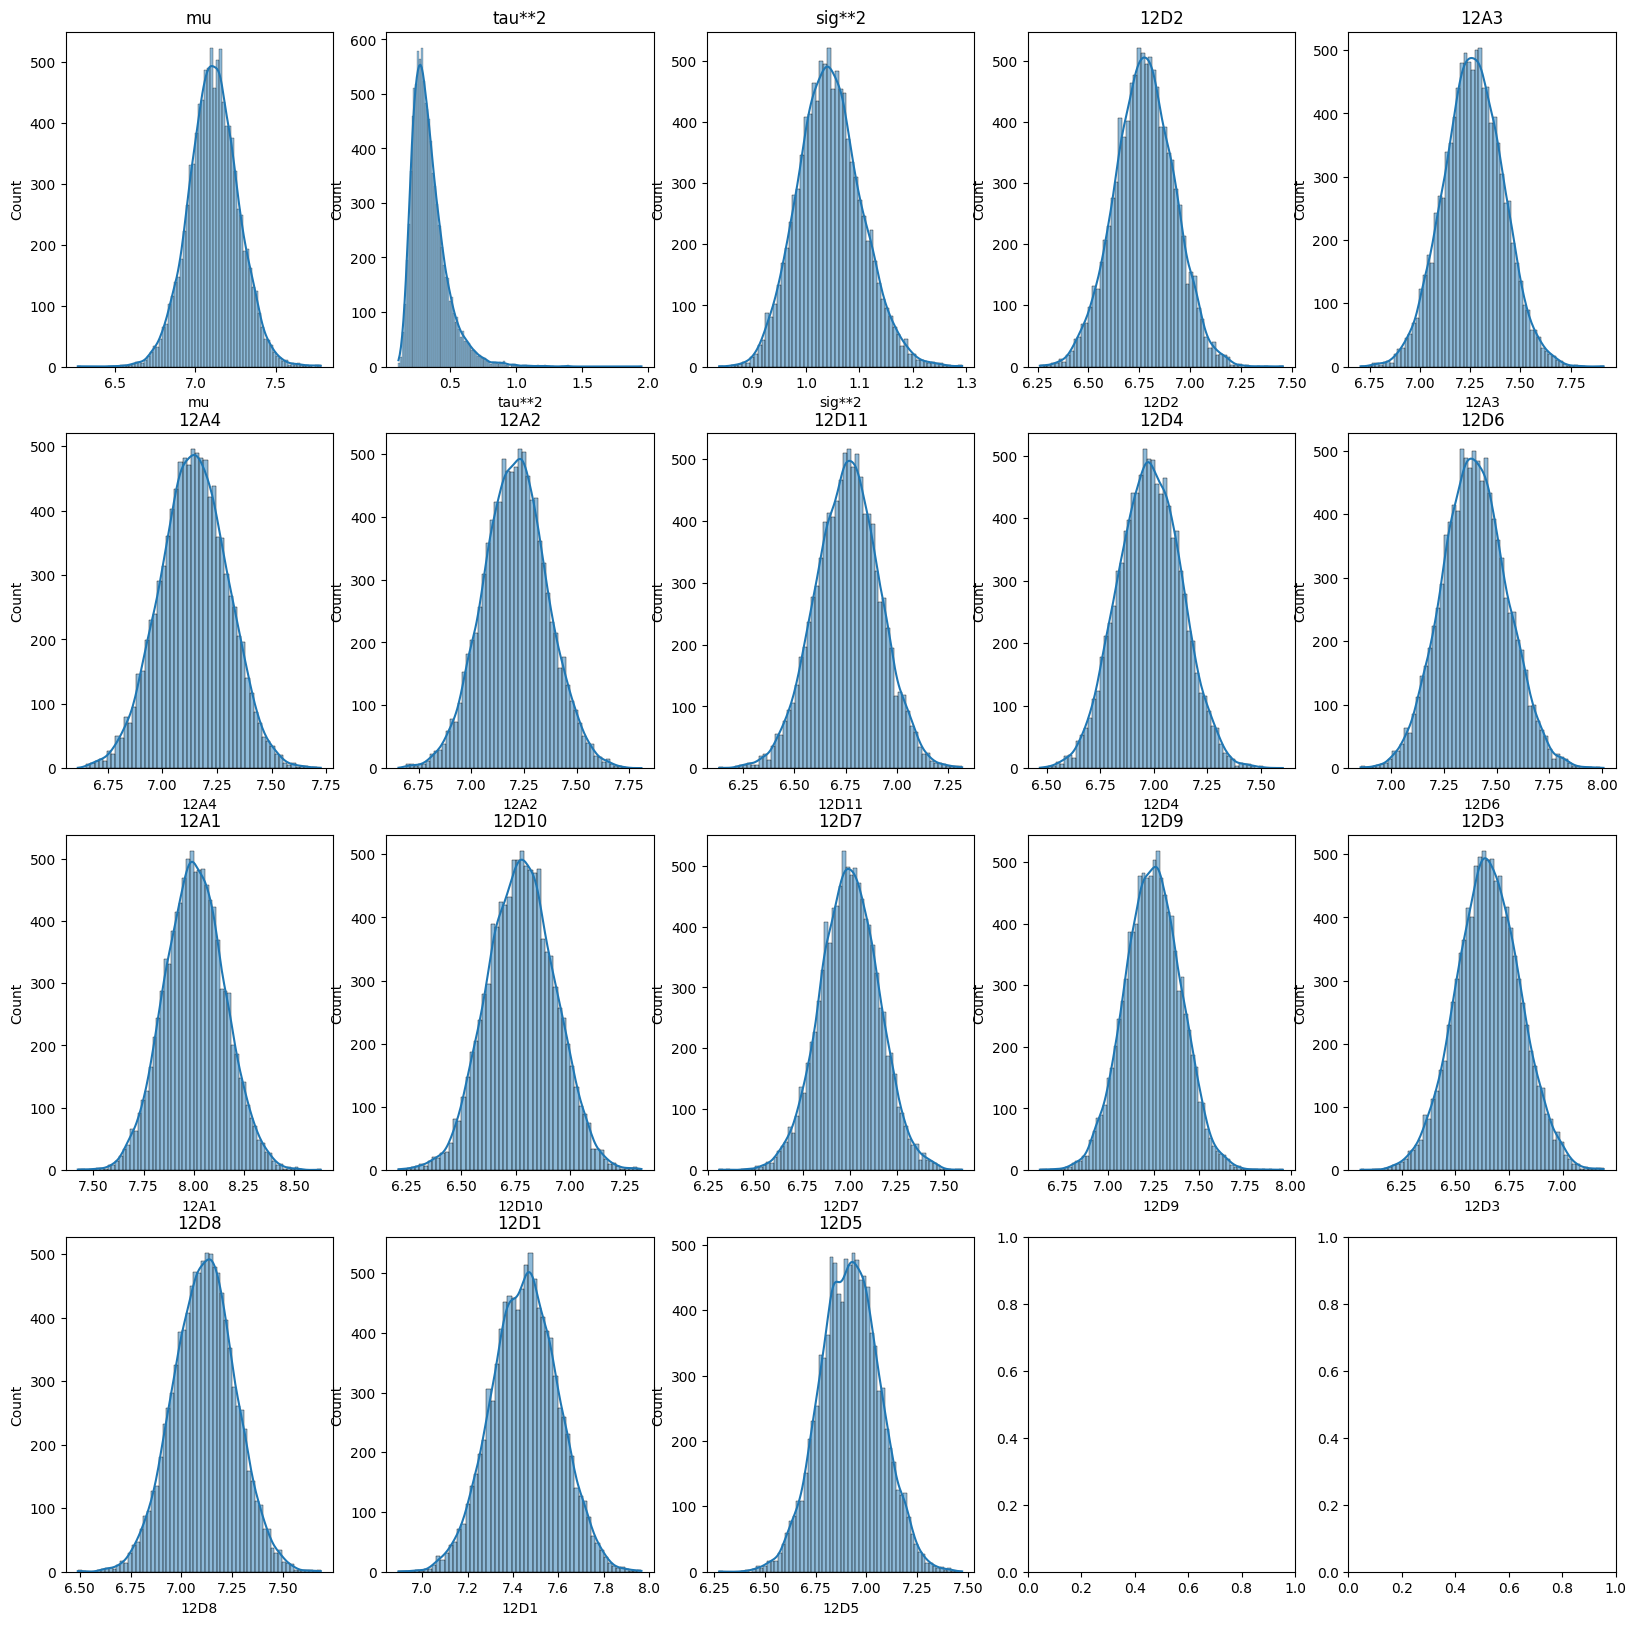

In [12]:
_, axs = plt.subplots(4, 5, figsize=(20, 20))
j = 0
k = 0
for i in para.columns:
    sns.histplot(data=para[i], ax=axs[j,k], kde = True)
    axs[j,k].set_title(i)
    k = k+1
    k = k % 5
    if k == 0:
        j = j+1

In [13]:
para.mean().sort_values(ascending = False)

12A1      8.005758
12D1      7.454402
12D6      7.395100
12A3      7.264773
12D9      7.245302
12A2      7.209075
12A4      7.143811
12D8      7.114130
mu        7.113251
12D7      7.000432
12D4      6.981139
12D5      6.920078
12D2      6.775827
12D10     6.775062
12D11     6.760426
12D3      6.653863
sig**2    1.044800
tau**2    0.341780
dtype: float64

In [14]:
para.var()

mu        0.024147
tau**2    0.018582
sig**2    0.003499
12D2      0.021361
12A3      0.021977
12A4      0.024002
12A2      0.023517
12D11     0.024933
12D4      0.022138
12D6      0.023600
12A1      0.022265
12D10     0.023352
12D7      0.024115
12D9      0.023680
12D3      0.022114
12D8      0.023296
12D1      0.021278
12D5      0.021928
dtype: float64

In [15]:
data_mean.sort_values(by = 'mean',ascending = False)

,category,mean
7,12A1,8.071111
13,12D1,7.482609
6,12D6,7.419512
1,12A3,7.277273
10,12D9,7.258537
3,12A2,7.214286
2,12A4,7.146341
12,12D8,7.114286
9,12D7,6.990000
5,12D4,6.968182


In [16]:
1 - sum(para['12D8'] - para['12D2'] > 0)/(len(para))

0.054400000000000004

In [17]:
list_of_data_groups = [data_cate['12D8'], data_cate['12D2']]
from scipy.stats import f_oneway
f_statistic, p_value = f_oneway(*list_of_data_groups)

print("F-Statistic:", f_statistic)
print("P-value:", p_value)

F-Statistic: 2.56630625396564
P-value: 0.1128723867433284


In [18]:
#Định nghĩa một số hàm cần dùng
def trace_plot(data, str):
    trace_values = np.zeros((len(data),), dtype=float)
    tmp = 0
    for i in range(len(data)):
        tmp += data[i]
        trace_values[i] = tmp/(i+1)
    plt.figure(figsize=(8, 4))
    plt.plot(trace_values, marker='', linestyle='-')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title(f'{str}')
    plt.grid(True)
    plt.show()

def trace_plot_var(data, str = " "):
    trace_values = np.zeros((len(data),), dtype=float)
    for i in range(len(data)):
        tmp = np.array(data[:i] - np.array(data[:i]).mean())
        trace_values[i] = np.dot(tmp, tmp) / (i if i > 0 else 1 )
        if( i > 1):
            if(trace_values[i] - trace_values[i-1]) > 25:
                print(i,data[i], trace_values[i] - trace_values[i-1])
    plt.figure(figsize=(8, 4))
    plt.plot(trace_values, marker='', linestyle='-')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title(f'{str}')
    plt.grid(True)
    plt.show()    

def autocorr(x, y, lag):
    #Hai chuỗi cần chung độ dài
    mean_x = sum(x)/len(x)
    mean_y = sum(y)/len(y)
    n = len(x)
    return np.dot(np.array(x[:n - lag] - mean_x), np.array(y[lag:] - mean_y)) / np.dot(np.array(x - mean_x), np.array(y-mean_y))
def ACF_plot(x,y, lag_max, str1 = " ", str2= " "):
    acf_values = [autocorr(x, y,lag) for lag in range(lag_max+1)]
    plt.figure(figsize=(8, 4))
    plt.stem([i for i in range(lag_max+1)], acf_values)
    #plt.bar(lag_max, acf_values)
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.title(f"Autocorrelation Function {str1} and {str2}")
    plt.grid(True)
    plt.show()

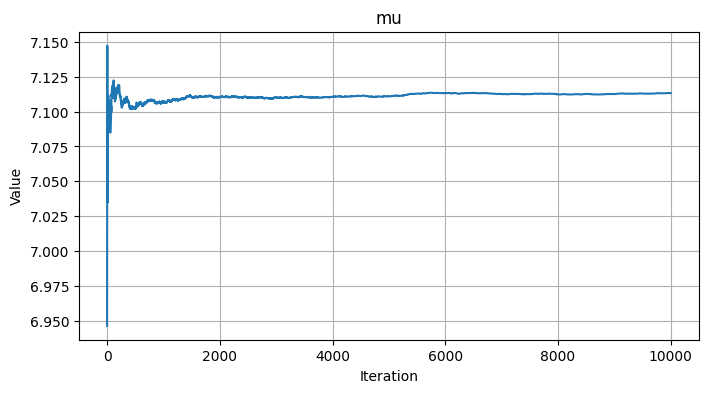

In [19]:
trace_plot(para['mu'], "mu")

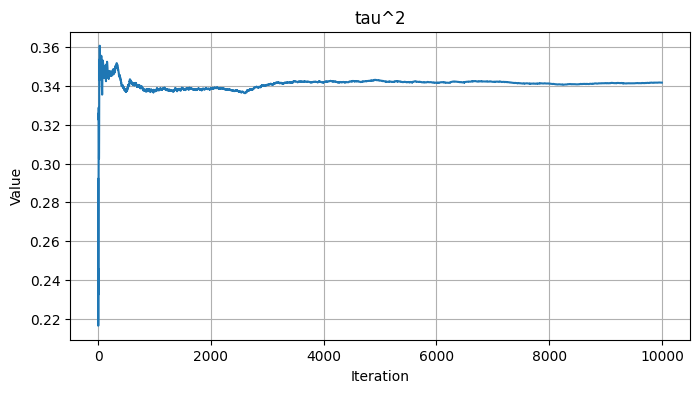

In [20]:
trace_plot(para['tau**2'], "tau^2")

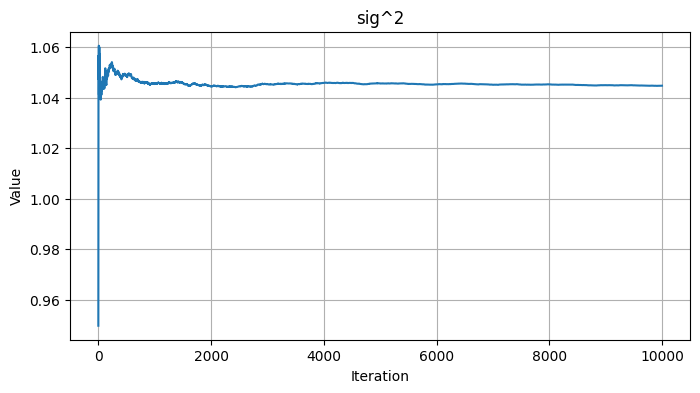

In [21]:
trace_plot(para['sig**2'], "sig^2")

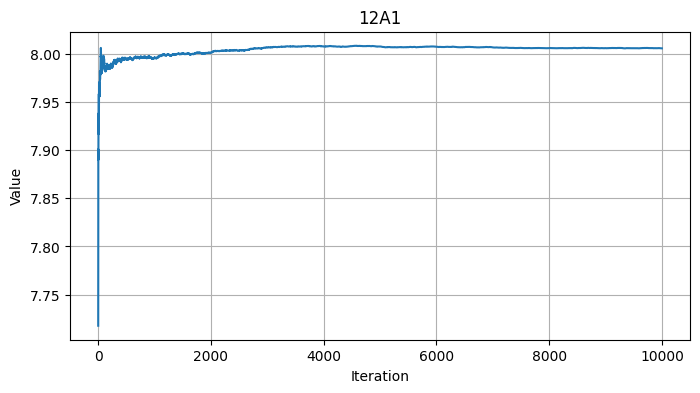

In [22]:
trace_plot(para['12A1'], '12A1')

C:\Users\KyThuat88\AppData\Local\Temp\ipykernel_16048\895368317.py:19: RuntimeWarning: Mean of empty slice.
  tmp = np.array(data[:i] - np.array(data[:i]).mean())
d:\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


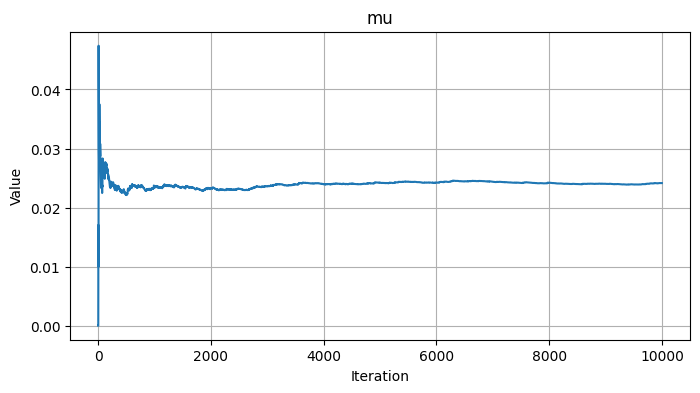

In [23]:
trace_plot_var(para['mu'], "mu")

C:\Users\KyThuat88\AppData\Local\Temp\ipykernel_16048\895368317.py:19: RuntimeWarning: Mean of empty slice.
  tmp = np.array(data[:i] - np.array(data[:i]).mean())


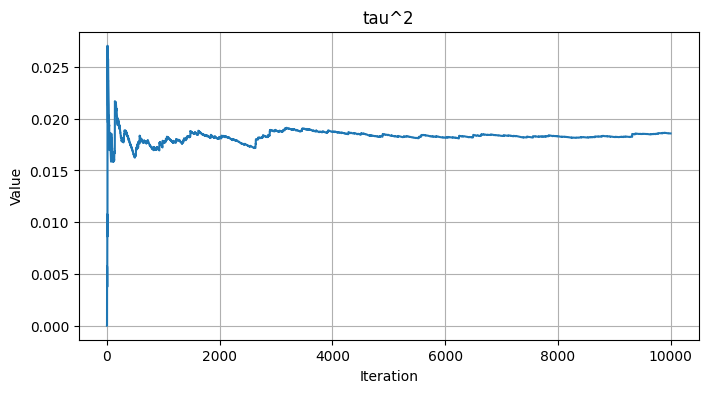

In [24]:
trace_plot_var(para['tau**2'], "tau^2")

C:\Users\KyThuat88\AppData\Local\Temp\ipykernel_16048\895368317.py:19: RuntimeWarning: Mean of empty slice.
  tmp = np.array(data[:i] - np.array(data[:i]).mean())


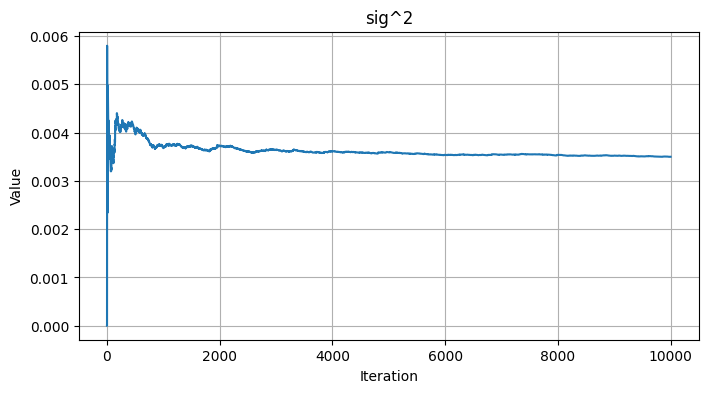

In [25]:
trace_plot_var(para['sig**2'], "sig^2")

C:\Users\KyThuat88\AppData\Local\Temp\ipykernel_16048\895368317.py:19: RuntimeWarning: Mean of empty slice.
  tmp = np.array(data[:i] - np.array(data[:i]).mean())


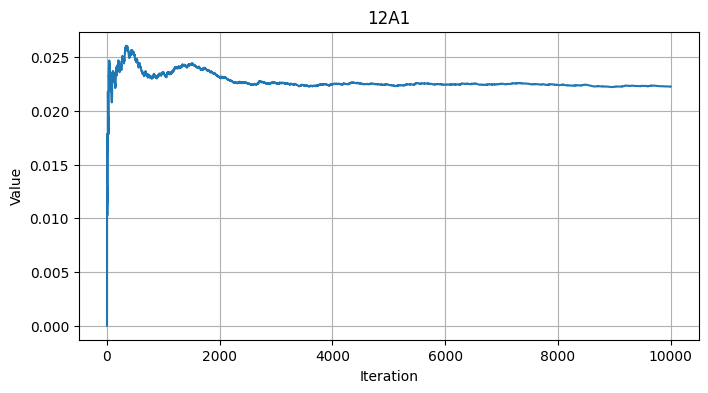

In [26]:
trace_plot_var(para['12A1'], "12A1")